## Kaggle LANL Earthquake Prediction Exploratory Data Analysis
### Kevin Maher
### Regis University MSDS696 Data Science Practicum II
### Associate Professor Dr. Robert Mason
#### May 2, 2019
#### Spring, 2019; In partial fullfillment of the Master of Science in Data Science degree, Regis University, Denver, CO
  

### Introduction

Presented here is an Exploratory Data Analysis (EDA) for the Kaggle Earthquake Prediction Challenge (Rouet-Leduc, et. al, 2019).  The modeling and machine learning portion of the project may be found in a separate Jupyter notebook within the github repository (https://github.com/Vettejeep/MSDS696-Masters-Final-Project). The goal of the project is to predict the time that an earthquake will occur in a laboratory test.  The laboratory test applies shear forces to a sample of earth and rock containing a fault line.  We note that these are laboratory earthquakes, not real earthquakes.  The simulated earthquakes tend to occur somewhat periodically because of the test setup, but this periodicity is not perfect or guaranteed to the modeler attempting to predict the time until an earthquake in the test data provided.  

The training input data consists of an acoustic signal that is over 629 million rows long.  Each acoustic signal value is associated with a time-to-failure, the time when an earthquake happens.  The test data consists of samples that are 150,000 samples long taken from earthquakes different from those in the test set.  There is therefore likely to be a need to examine the data in 150,000 sample chunks that represent the test signals.

The signal is recorded at 4MHz which is an extremely high sample rate for an acoustic sensor.  A complicating factor is that the signal is recorded in bins that are 4096 samples in length.  There is a 12 microsecond gap between bins.  This means that there are 46-48 samples of lost data in each gap depending on how the gap is interpreted.  The location of the gaps are not given to challenge participants (Rouet-Leduc, 2019).  Given the noise level of the signal it would appear to be impossible to attempt reconstruction of the missing data.  Further, there are not the same number of missing samples in each of the 150k long test sample files because 4096 does not evenly divide into 150,000.  Because of the difficulty in reconstructing the missing data, or knowing where it is, it has been decided to proceed with continuous signal processing techniques even though that is not strictly perfect.

### Publication

In an effort to comply with both university and Kaggle requirements, this Jupyter notebook is being published on GitHub and on Kaggle. The notebook was designed for a university course. It has not been tested in the Kaggle environment.  Plotting has not yet been implemented on Kaggle, I will try to do it when my course work is complete.  This discloses my code which is being submitted and shared to my professor and class for grading.  The machine learning model notebook for this project will also be published in the same manner.

### Test Environment

Designed and run in a Python 3 Anaconda environment on a Windows 10 computer.  

In [1]:
import sys
import scipy
import matplotlib
import numpy as np
import pandas as pd
print(sys.version)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('scipy:', scipy.__version__)
print('matplotlib:', matplotlib.__version__)

3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
pandas: 0.23.4
numpy: 1.16.3
scipy: 1.1.0
matplotlib: 3.0.3


### Code Setup

These are the needed library imports for problem setup.  Many of these libraries request a citation when used in an academic paper.  Numpy is utilized to provide many numerical functions needed in the EDA (van der Walt, Colbert & Varoquaux, 2011). Pandas is very helpful for its ability to support data manipulation (McKinney, 2010).  SciPy is utilized to provide signal processing functions (Jones E., et al, 2001).  Matplotlib is used for plotting (Hunter, 2007).  The Jupyter environment in which this code is presented and was run is a descendant of the IPython environment originated by Pérez & Granger (2007).

In [2]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import scipy.signal as sg
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

Define some constants for data location.

In [3]:
DATA_DIR = r'd:\#earthquake\data'  # set for local environment!
TEST_DIR = r'd:\#earthquake\data\test'  # set for local environment!

Load the data, this takes a while.  There are over 629 million data rows.  This data requires over 10GB of storage space on the computer's hard drive.

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
print(train_df.shape)

FileNotFoundError: File b'd:\\#earthquake\\data/train.csv' does not exist

### Exploratory Data Analysis

Lets validate the test files.  This verifies that they all contain 150,000 samples as expected.

In [5]:
ld = os.listdir(TEST_DIR)
sizes = np.zeros(len(ld))

for i, f in enumerate(ld):
    df = pd.read_csv(os.path.join(TEST_DIR, f))
    sizes[i] = df.shape[0]

print(np.mean(sizes))  # all were 150,000
print(np.min(sizes))
print(np.max(sizes))

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\#earthquake\\data\\test'

A basic time series plot of the raw data.  Because of the length of the data, the plot samples every 100th data point. These plots are very common on the Kaggle site's kernels section, this one is taken from Preda (2019).  Earthquakes occur when the time-to-failure signal (blue) jumps up from very near zero to a much higher value where that new higher value is the time to what is then the next quake.  There appears to be a short term high amplitude oscillation very shortly before each quake.  But, there also several similar such peaks that occur nearer the region centered in time between quakes.  Signal noise seems to increase as time gets closer to failure, though there is also a drop after the big peak.  A signal's standard deviation may prove to be a helpful predictor.  The region just after the big peak may be especially hard to predict.

In [6]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='tab:orange')
    ax1.set_ylabel('acoustic data', color='tab:orange')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='tab:blue')
    ax2.set_ylabel('time to failure', color='tab:blue')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

NameError: name 'train_df' is not defined

From the above plot we can see that 16 earthquakes occur in the data.  The earthquakes happen when the time-to-failure reaches very nearly zero and then jumps up.  There are only 15 complete time ramps that result in an earthquake and 2 incomplete time ramps.  One challenge of this competition is that there are only these very few earthquakes to work with.  The is a signal spike (high amplitude) just before an earthquake, but there are also signal spikes in other places that may complicate matters.  While the acoustic signal is very large at over 600m rows, the very small number of actual earthquakes available will make machine learning a challenge.

Having validated that the test samples are 150,000 samples long, it could help to examine the training data in 150,000 sample chunks.  Here are some random samples of the training data and plots of the acoustic signal along with the time-to-failure.  Note that the y-axis scales vary for all plots.  It is very interesting that the high level spike in the signal occurs in row 3, column 1 in a signal only 0.32 seconds before failure.  This spike reaches vales above 2000 and below 4000.  A similar situation occurs in row 4, column 2.  Contrast this with other plots where the time-to-failure is many seconds away and the signal level peaks around 100.  Time-to-failure plots as a ramp because we are slowly approaching the next quake as the signal progresses in time.  Apparently the time-to-failure has limited resolution and so is represented by a stair step rather than a smooth line.  It appears that if signal spikes could be captured in some way it might help the effort to model time-to-failure.  Somewhat shockingly, we are trying to predict an earthquake from only around 0.04 seconds or so worth of data, as can be noted from examining the right hand axes of the plots. 

NameError: name 'train_df' is not defined

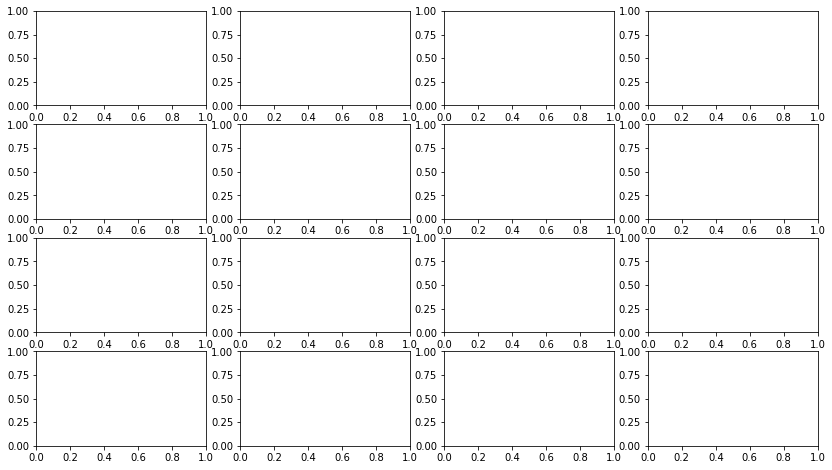

In [7]:
# plot 150k sample slices of the training data, matches size of test data (~0.375 seconds long)
# plots signal and decreasing time to the next quake
np.random.seed(2018)
rand_idxs = np.random.randint(0, 629145480-150000, size=16, dtype=np.int32)
f, axes = plt.subplots(4, 4, figsize=(14, 8))
i = 0
j = 0

for st_idx in rand_idxs:
    ad = train_df['acoustic_data'].values[st_idx: st_idx + 150000]
    ttf = train_df['time_to_failure'].values[st_idx: st_idx + 150000]
    
    axes[j][i].plot(ad, color='tab:orange')
    
    s = axes[j][i].twinx()
    s.plot(ttf, color='tab:blue')
    
    i += 1
    if i >= 4:
        i = 0
        j += 1

plt.tight_layout()
plt.show()
del ad, ttf

Find the indices for where the earthquakes occur, then plotting may be performed in the region around failure.

In [8]:
ttf_diff = train_df['time_to_failure'].diff()
ttf_diff = ttf_diff.loc[ttf_diff > 0]
print(ttf_diff.index)

NameError: name 'train_df' is not defined

Below is a look at the signal just before failure (an earthquake).  It is very interesting that the signal becomes quiet in the 150k sample slice before an earthquake.  Thus, the signal spike observed in the big picture plot above must occur more than one slice (more than 150k samples) before the earthquake.  These do not appear much different than plots 5 or even 8 seconds before the quake that are presented above where the time to failure ramps are shown.  This looks like it will create major problems for accurate prediction.  Earthquakes are deemed to have occurred where the blue line jumps up in value, representing the time to the next quake.

NameError: name 'train_df' is not defined

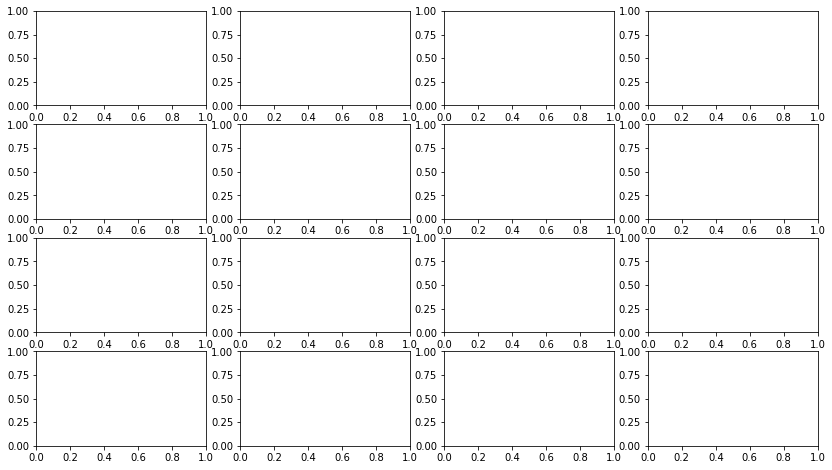

In [9]:
# plot -150,000 to +30000 samples right around the earthquake
failure_idxs = [5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
                245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
                495800225, 528777115, 585568144, 621985673]
f, axes = plt.subplots(4, 4, figsize=(14, 8))
i = 0
j = 0

for idx in failure_idxs:
    ad = train_df['acoustic_data'].values[idx - 150000: idx + 30000]
    ttf = train_df['time_to_failure'].values[idx - 150000: idx + 30000]
    
    axes[j][i].plot(ad, color='tab:orange')
    
    s = axes[j][i].twinx()
    s.plot(ttf, color='tab:blue')
    
    i += 1
    if i >= 4:
        i = 0
        j += 1

plt.tight_layout()
plt.show()
del ad, ttf

By expanding the time to failure plots, it appears that the big spike in the signal before failure is remarkably consistent.  The problem is that the 150k sample slices are actually very short compared to the overall time between quakes and thus these big apparently meaningful signal spikes are unlikely to be present in many training or test samples.  If slicing the training data directly into 150k chunks, then only 16 of 4194 training samples (0.38%) would contain a meaningful high-valued spike.  It is possible that the analysis of these spikes in some manner could add predictive capability to any small number of test samples that might contain these features, this possibility has not been explored by this author yet.

NameError: name 'train_df' is not defined

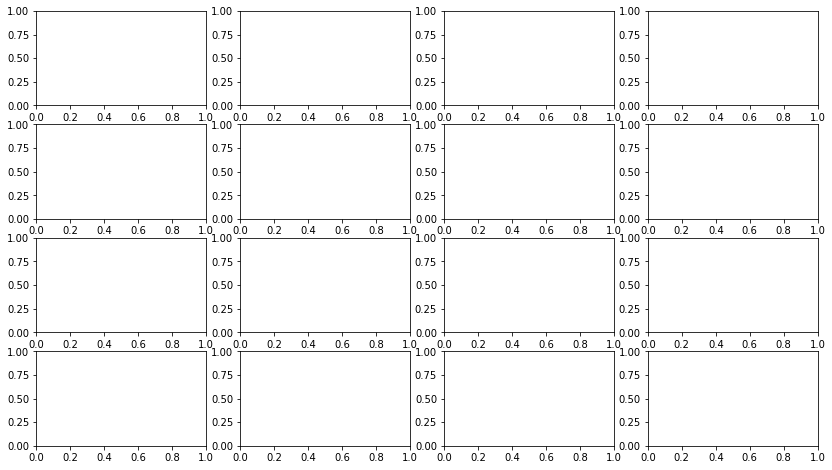

In [10]:
f, axes = plt.subplots(4, 4, figsize=(14, 8))
i = 0
j = 0

for idx in failure_idxs:
    ad = train_df['acoustic_data'].values[idx - 2000000: idx + 30000]
    ttf = train_df['time_to_failure'].values[idx - 2000000: idx + 30000]
    
    axes[j][i].plot(ad, color='tab:orange')
    axes[j][i].set_xticklabels([])
    
    s = axes[j][i].twinx()
    s.plot(ttf, color='tab:blue')
    
    i += 1
    if i >= 4:
        i = 0
        j += 1

plt.tight_layout()
plt.show()
del ad, ttf

A check of the test data in the time domain is presented below, it is difficult to tell from such short signal bursts if they match the character of the training data.  None of the very high valued signal spikes were caught in a partial look at the test data.  However, these are rare and the existence of the spikes will be taken up again later. 

In [11]:
# plot test signals
ld = os.listdir(TEST_DIR)
ld = ld[32:48]
f, axes = plt.subplots(4, 4, figsize=(14, 8))
i = 0
j = 0
    
for sig_file in ld:
    sig = pd.read_csv(os.path.join(TEST_DIR, sig_file))['acoustic_data']
    axes[j][i].plot(sig, color='tab:orange')

    i += 1
    if i >= 4:
        i = 0
        j += 1

plt.tight_layout()
plt.show()
del sig

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\#earthquake\\data\\test'

Frequency components of the signal could be very interesting to look at.  This is a plot of the Fourier transform magnitude for some of the test signals.  Note that there appears to be little information in the signal above the 20,000th frequency line.  Noise appears to mostly disappear above the 25,000th frequency line.  It is difficult to translate this to a frequency because of the signal gaps noted earlier.  Still, it may be best to concentrate signal analysis on frequencies below those represented by the 20,000th frequency line.  Also, there are peaks in the frequency analysis that may be valuable to collect in some manner.  The DC component was eliminated for plotting purposes because it would otherwise dominate the plot and make the other frequencies hard to see.  Also note that while referred to as an "FFT" in the code below, this is actually a Discreet Fourier Transform (DFT) because the signal length of 150k samples is not a number that is a power of two.

In [12]:
# plot frequency components of the signal
MAX_FREQ_IDX = 75000

signals = ld[0:12]
fig = plt.figure(figsize=(12, 5))

for i, signal in enumerate(signals):
    df = pd.read_csv(os.path.join(TEST_DIR, signal))
    ad = df['acoustic_data'].values
    ad = ad - np.mean(ad)  # remove DC component, otherwise it dominates the plot

    b, a = sg.butter(6, Wn=20000 / 75000)
    ad = sg.lfilter(b, a, ad)

    zc = np.fft.fft(ad)
    zc = zc[:75000]  # eliminate aliased portion of signal per Nyquist criteria

    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)

    plt.subplot(4, 3, i+1)
    plt.plot(magFFT, color='tab:blue')

plt.tight_layout()
plt.show()

NameError: name 'ld' is not defined

This is a set of plots of the Fourier transform, windowed by short cosine tapers near the ends.  The idea of using the window is to avoid any start up transients that might cause ringing in filters applied to the signal.  It is very interesting that windowing seems to emphasize noise.  This noise, however, would almost entirely be removed by a low pass or band pass filter.  Windows are used to force the signal to be periodic in the time domain which reduces leakage effects at the signal endpoints in the Fourier transform.

In [13]:
# plot frequency components of the signal with a gentle window
import warnings
from scipy.signal import hann
warnings.filterwarnings("ignore")
MAX_FREQ_IDX = 75000
ld = os.listdir(TEST_DIR)
signals = ld[0:12]
fig = plt.figure(figsize=(12, 5))

for i, signal in enumerate(signals):
    df = pd.read_csv(os.path.join(TEST_DIR, signal))
    ad = df['acoustic_data'].values
    ad = ad - np.mean(ad)  # remove DC component, otherwise it dominates the plot

    hann_win = sg.hanning(M=24)
    ad_beg = ad[0: 12] * hann_win[0: 12]
    ad_end = ad[-12:] * hann_win[-12:]
    ad = np.concatenate((ad_beg, ad[12: -12], ad_end), axis=0)

    zc = np.fft.fft(ad)
    zc = zc[:75000]  # eliminate aliased portion of signal per Nyquist criteria

    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)

    plt.subplot(4, 3, i+1)
    plt.plot(magFFT, color='tab:blue')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\#earthquake\\data\\test'

Phase plots for the Fourier transform.  The signal was windowed by small sections taken from a Hanning window along the edges in order to not cause an impulse-like transient in a potential filter at start-up.  Phase plots show what appears to be just noise. Probably limited phase features will be all that is desired for the model, perhaps just the standard deviation.

In [14]:
import warnings
from scipy.signal import hann
warnings.filterwarnings("ignore")
MAX_FREQ_IDX = 75000
ld = os.listdir(TEST_DIR)
signals = ld[0:12]
fig = plt.figure(figsize=(12, 5))

for i, signal in enumerate(signals):
    df = pd.read_csv(os.path.join(TEST_DIR, signal))
    ad = df['acoustic_data'].values
    ad = ad - np.mean(ad)  # remove DC component, otherwise it dominates the plot

    hann_win = sg.hanning(M=24)
    ad_beg = ad[0: 12] * hann_win[0: 12]
    ad_end = ad[-12:] * hann_win[-12:]
    ad = np.concatenate((ad_beg, ad[12: -12], ad_end), axis=0)

    zc = np.fft.fft(ad)
    zc = zc[:75000]  # eliminate aliased portion of signal per Nyquist criteria

    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)

    plt.subplot(4, 3, i+1)
    plt.plot(phzFFT, color='tab:blue')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\#earthquake\\data\\test'

From the code below, the test set "big peaks" seem to match the proportion with which they are found in the training data at 0.38% of signals (test set signals are all 150k samples long).  The number of earthquakes in the training set seems to be approximately proportional to the overall size relationship between the two sets. With 16 quakes in the training set we might expect 10 quakes in the test set based on their relative sizes.  As seen by the code output, there are 10 such files within the test set that exhibit the peak behavior.   However, there is also concern about the possibility of bogus peaks in the test data that do not correlate well with an actual quake.  The expectation of 10 possible quakes in the test set should be considered cautiously and as only an approximation.

In [15]:
# determine is a signal contains a 'big peak' as defined by an absolute value more than 2000
ld = os.listdir(TEST_DIR)
peaks = np.zeros(len(ld))

for i, f in enumerate(ld):
    df = pd.read_csv(os.path.join(TEST_DIR, f))
    peaks[i] = df['acoustic_data'].abs().max()
    
peaks_lg = peaks[peaks >= 2000.0] 
print(peaks_lg.shape[0])
print(np.float32(peaks_lg.shape[0]) / np.float32(peaks.shape[0]) * 100.0)
print(np.float32(2624) / np.float32(4194) * 16)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\#earthquake\\data\\test'

### Conclusions

It appears that this will be a difficult problem and that error is likely to be high relative to the mean time-to-failure.  There do not seem to be many obvious features in the signal to correlate with the time to system failure (an earthquake).  An examination of the Kaggle leader board confirms this as even the best scores show significant error as of the date of this Jupyter notebook.  The most obvious feature is the big signal spike just before failure.  But, as noted, it is only present in about 0.38% of 150k sample training slices.  This may make it a difficult feature to work with and 99.6% of the time the quake needs to be predicted in the absence of the major signal spike.  A great starting approach for generating features to model this problem appears to be the mass statistical feature generation used by many scripts on the Kaggle kernels section.  Much of this feature generation seems to be come from work by Lukayenko (2019), and others credited by citations in his Kaggle kernel.

The author's plan for modeling is to use the Preda (2019) kernel as a starting point for feature generation and add band pass and low pass filtering to generate additional features.  The Preda model utilizes the real and imaginary parts of the Fourier transform.  This author will be working primarily with the traditional magnitude and phase output.  Because Fourier transform phase information appears to be essentially noise, most Fourier statistics will likely be based on magnitude information.  

### Author Information

Kevin Maher  
Email: Vettejeep365@gmail.com  
Upvotes and/or github stars appreciated!  
This code herein has been released under the
<a href="http://www.apache.org/licenses/LICENSE-2.0"><span style='color:#337AB7;text-decoration:
none;text-underline:none'>Apache 2.0
</span></a> open source license.  
The author please requests a citation for the use or derivation of this work.

### References

Hunter, J., (2007). Matplotlib: A 2D Graphics Environment.  <i>Computing in Science & Engineering</i>, 9, 90-95, DOI:10.1109/MCSE.2007.55

Jones E., et al (2001). SciPy: Open Source Scientific Tools for Python, Retrieved from: http://www.scipy.org/ 

Lukayenko, A. (2019).  Earthquakes FE. More features and samples.  <i>Kaggle</i>.  Retrieved from: https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples 

McKinney, W., (2010). Data Structures for Statistical Computing in Python.  <i>Proceedings of the 9th Python in Science Conference</i>, 51-56.

Pérez, F. & Granger, B., (2007). IPython: A System for Interactive Scientific Computing.  <i>Computing in Science & Engineering</i>, 9, 21-29, DOI:10.1109/MCSE.2007.53

Preda, G (2019).  LANL Earthquake EDA and Prediction.  <i>Kaggle</i>.  Retrieved from: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction 

Rouet-Leduc, B., et al (2019).  LANL Earthquake Prediction.  <i>Kaggle</i>.  Retrieved from: https://www.kaggle.com/c/LANL-Earthquake-Prediction

Rouet-Leduc, B. (2019).  Additional Info.  Kaggle.  Retrieved from:https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526#latest-522727 

van der Walt, S., Colbert, S. & Varoquaux, G (2011). The NumPy Array: A Structure for Efficient Numerical Computation.  <i>Computing in Science & Engineering</i>, 13, 22-30, DOI:10.1109/MCSE.2011.37.